In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
# import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

In [2]:
# Loading the dataset
df = pd.read_csv("Data/train.csv")

In [3]:
df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [4]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [6]:
## EDA

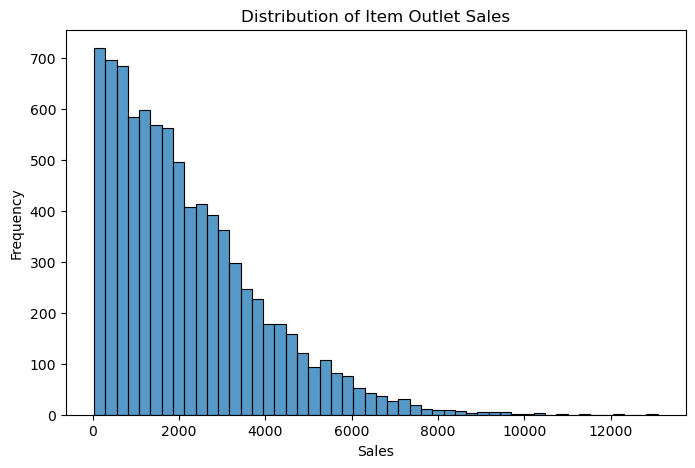

In [7]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Item_Outlet_Sales'], bins=50)
plt.title("Distribution of Item Outlet Sales")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

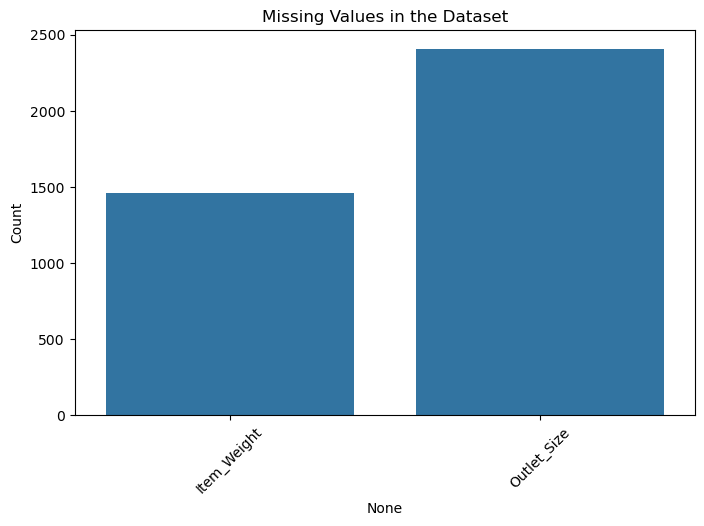

In [8]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values()

plt.figure(figsize=(8, 5))
sns.barplot(x=missing_values.index, y=missing_values.values)
plt.title("Missing Values in the Dataset")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

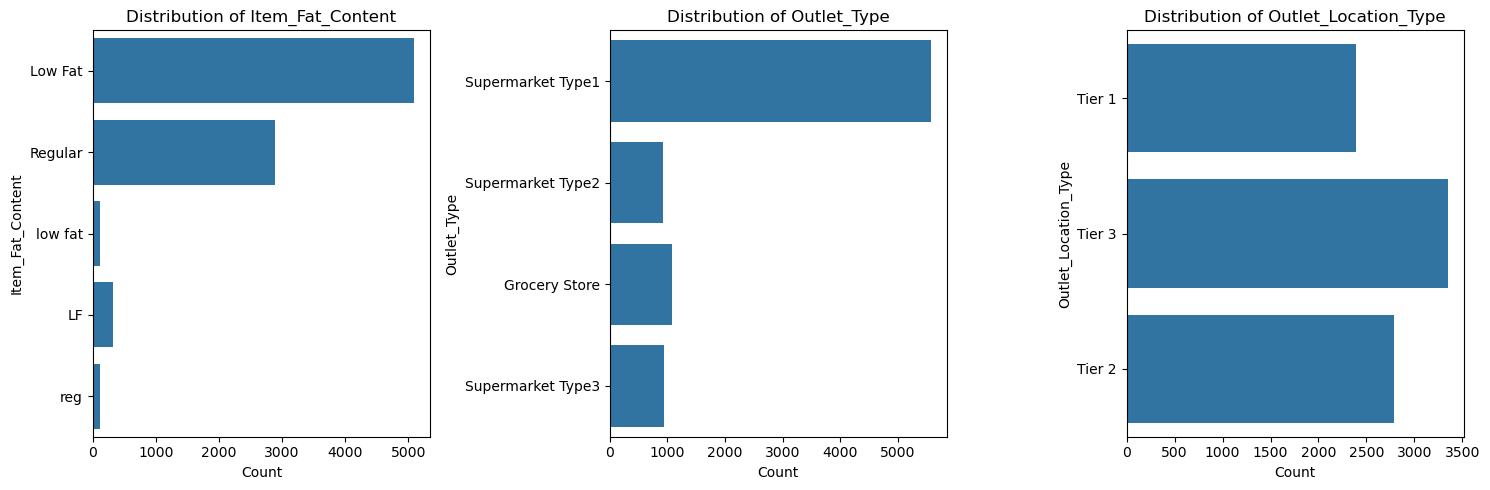

In [9]:
categorical_features = ["Item_Fat_Content", "Outlet_Type", "Outlet_Location_Type"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(categorical_features):
    sns.countplot(y=df[col], ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel("Count")

plt.tight_layout()
plt.show()

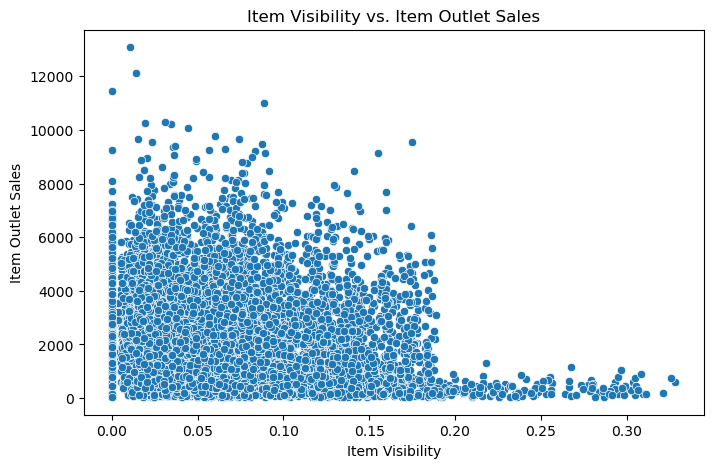

In [10]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["Item_Visibility"], y=df["Item_Outlet_Sales"])
plt.title("Item Visibility vs. Item Outlet Sales")
plt.xlabel("Item Visibility")
plt.ylabel("Item Outlet Sales")
plt.show()

In [11]:
# Handle Missing Values
df['Item_Weight'].fillna(df.groupby('Item_Identifier')['Item_Weight'].transform('median'), inplace=True)
df['Outlet_Size'].fillna(df.groupby('Outlet_Type')['Outlet_Size'].transform(lambda x: x.mode()[0] if not x.mode().empty else "Medium"), inplace=True)

C:\Users\arvin\AppData\Local\Temp\ipykernel_42760\4287853682.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Item_Weight'].fillna(df.groupby('Item_Identifier')['Item_Weight'].transform('median'), inplace=True)
C:\Users\arvin\AppData\Local\Temp\ipykernel_42760\4287853682.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which 

In [12]:
df['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

In [13]:
# Handling variable "Item_Fat_Content" item names
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'})

In [14]:
# Extracting year from respect to current year from Store_Age
# replacing zero values with the median visibility of the same Item_Identifier group

df['Store_Age'] = 2025 - df['Outlet_Establishment_Year']
df['Item_Visibility'] = df.groupby('Item_Identifier')['Item_Visibility'].transform(lambda x: x.replace(0, x.median()))

In [15]:
# Performing Dummmy Encoding
categorical_cols = ['Outlet_Type', 'Outlet_Location_Type', 'Outlet_Size', 'Item_Fat_Content', 'Item_Type']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [16]:
df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Identifier', 'Outlet_Establishment_Year', 'Item_Outlet_Sales',
       'Store_Age', 'Outlet_Type_Supermarket Type1',
       'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3',
       'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3',
       'Outlet_Size_Medium', 'Outlet_Size_Small', 'Item_Fat_Content_Regular',
       'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
       'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods'],
      dtype='object')

In [17]:
# Removing columnd 'Item_Identifier', 'Outlet_Identifier', 'Outlet_Establishment_Year'
drop_cols = ['Item_Identifier', 'Outlet_Identifier', 'Outlet_Establishment_Year']
df = df.drop(columns=drop_cols)

In [18]:
# Train-Test Split
X = df.drop(columns=['Item_Outlet_Sales'])
y = df['Item_Outlet_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
X.columns

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Store_Age',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Size_Medium',
       'Outlet_Size_Small', 'Item_Fat_Content_Regular', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods', 'Item_Type_Soft Drinks',
       'Item_Type_Starchy Foods'],
      dtype='object')

In [20]:
# Standardization using Standard Scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
# Training (Random Forest & XGBoost)
rf = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

xgb_model = XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.05, subsample=0.8, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

In [22]:
# Hyperparameter Tuning (XGBoost)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 10],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.8, 1]
}

grid_search = GridSearchCV(XGBRegressor(random_state=42), param_grid, scoring='neg_root_mean_squared_error', cv=5, verbose=1)
grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)
rmse_best_xgb = np.sqrt(mean_squared_error(y_test, y_pred_best_xgb))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\arvin\AppData\Local\Temp\ipykernel_42760\4289490078.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df[:10], palette='viridis')


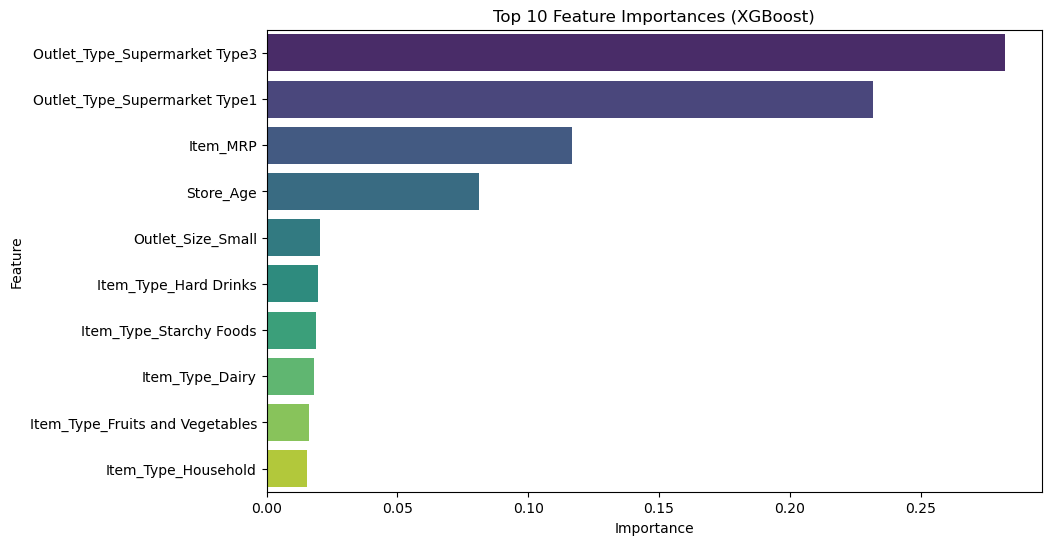

RF RMSE: 1039.0993362207093
XGBoost RMSE: 1075.6007460078883
Fined Tuned XGBoost RMSE: 1034.1604401292716


In [23]:
# Feature Importance
importances = best_xgb.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df[:10], palette='viridis')
plt.title('Top 10 Feature Importances (XGBoost)')
plt.show()

# Print RMSE Scores
print(f'RF RMSE: {rmse_rf}')
print(f'XGBoost RMSE: {rmse_xgb}')
print(f'Fined Tuned XGBoost RMSE: {rmse_best_xgb}')


### Loading Test Data

In [24]:
actual_test_data = pd.read_csv("Data/test.csv")

In [25]:
actual_test_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [26]:
actual_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                4705 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


In [27]:
# Handle Missing Values
actual_test_data['Item_Weight'].fillna(actual_test_data.groupby('Item_Identifier')['Item_Weight'].transform('median'), inplace=True)
actual_test_data['Outlet_Size'].fillna(actual_test_data.groupby('Outlet_Type')['Outlet_Size'].transform(lambda x: x.mode()[0] if not x.mode().empty else "Medium"), inplace=True)

C:\Users\arvin\AppData\Local\Temp\ipykernel_42760\2039120262.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  actual_test_data['Item_Weight'].fillna(actual_test_data.groupby('Item_Identifier')['Item_Weight'].transform('median'), inplace=True)
C:\Users\arvin\AppData\Local\Temp\ipykernel_42760\2039120262.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the i

In [28]:
# Handling variable "Item_Fat_Content" item names
actual_test_data['Item_Fat_Content'] = actual_test_data['Item_Fat_Content'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'})

In [29]:
# Extracting year from respect to current year from Store_Age
# replacing zero values with the median visibility of the same Item_Identifier group
actual_test_data['Store_Age'] = 2025 - actual_test_data['Outlet_Establishment_Year']
actual_test_data['Item_Visibility'] = actual_test_data.groupby('Item_Identifier')['Item_Visibility'].transform(lambda x: x.replace(0, x.median()))

In [30]:
actual_test_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Store_Age
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1,26
1,FDW14,8.300,Regular,0.038428,Dairy,87.3198,OUT017,2007,Small,Tier 2,Supermarket Type1,18
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,Small,Tier 3,Grocery Store,27
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,Small,Tier 2,Supermarket Type1,18
4,FDY38,13.600,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3,40


In [31]:
# Performing Dummmy Encoding
categorical_cols = ['Outlet_Type', 'Outlet_Location_Type', 'Outlet_Size', 'Item_Fat_Content', 'Item_Type']
actual_test_data = pd.get_dummies(actual_test_data, columns=categorical_cols, drop_first=True)

In [32]:
actual_test_data.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Store_Age,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,...,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods
0,FDW58,20.750,0.007565,107.8622,OUT049,1999,26,True,False,False,...,False,False,False,False,False,False,False,True,False,False
1,FDW14,8.300,0.038428,87.3198,OUT017,2007,18,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,NCN55,14.600,0.099575,241.7538,OUT010,1998,27,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,FDQ58,7.315,0.015388,155.0340,OUT017,2007,18,True,False,False,...,False,False,False,False,False,False,False,True,False,False
4,FDY38,13.600,0.118599,234.2300,OUT027,1985,40,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [33]:
actual_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Item_Identifier                  5681 non-null   object 
 1   Item_Weight                      5661 non-null   float64
 2   Item_Visibility                  5681 non-null   float64
 3   Item_MRP                         5681 non-null   float64
 4   Outlet_Identifier                5681 non-null   object 
 5   Outlet_Establishment_Year        5681 non-null   int64  
 6   Store_Age                        5681 non-null   int64  
 7   Outlet_Type_Supermarket Type1    5681 non-null   bool   
 8   Outlet_Type_Supermarket Type2    5681 non-null   bool   
 9   Outlet_Type_Supermarket Type3    5681 non-null   bool   
 10  Outlet_Location_Type_Tier 2      5681 non-null   bool   
 11  Outlet_Location_Type_Tier 3      5681 non-null   bool   
 12  Outlet_Size_Medium  

In [34]:
# Feature Selection
drop_cols = ['Item_Identifier', 'Outlet_Identifier', 'Outlet_Establishment_Year']
actual_test_data = actual_test_data.drop(columns=drop_cols)

In [35]:
actual_test_data.head()

,Item_Weight,Item_Visibility,Item_MRP,Store_Age,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Size_Medium,...,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods
0,20.750,0.007565,107.8622,26,True,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
1,8.300,0.038428,87.3198,18,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,14.600,0.099575,241.7538,27,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
3,7.315,0.015388,155.0340,18,True,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
4,13.600,0.118599,234.2300,40,False,False,True,False,True,True,...,False,False,False,False,False,False,False,False,False,False


In [36]:
# Applying Standarded Scaler
scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
actual_test_data_std = scaler.fit_transform(actual_test_data)

In [37]:
test_pred_rf = pd.read_csv("Data/test.csv")
test_pred_xg = pd.read_csv("Data/test.csv")


In [38]:
test_pred_rf['Item_Outlet_Sales'] = rf.predict(actual_test_data_std)

In [39]:
test_pred_rf.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1,1668.763313
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1,1342.957446
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store,550.281107
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1,2287.051166
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3,6576.050130


In [40]:
test_pred_xg['Item_Outlet_Sales'] = best_xgb.predict(actual_test_data_std)


In [41]:
test_pred_xg.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1,313.799377
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1,1203.728271
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store,638.482727
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1,2227.703369
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3,6765.186523


In [42]:
test_pred_xg.columns


Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [43]:
selected_columns = ['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales']
test_pred_rf[selected_columns].to_csv("test_rf_prediction.csv", index=False)
test_pred_xg[selected_columns].to_csv("test_xg_prediction.csv", index=False)